Notebook written to work in Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/quora-question-pairs/

/content/drive/My Drive/quora-question-pairs


In [ ]:
from torchtext.data import Field, TabularDataset, BucketIterator, Example, Iterator
import torchtext.vocab as vocab
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# from tqdm import tqdm
from tqdm.notebook import tqdm
import re
import numpy as np
import pandas as pd
from sklearn import model_selection
import matplotlib.pyplot as plt
%matplotlib inline

from layers import RNNDropout

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
BATCH_SIZE = 512

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data = pd.read_csv("input/train.csv", 
                   nrows=20000
                   )

In [ ]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


###  Cleaning the text

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",'i\'m':'i am', "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled'}

def clean_contractions(text, mapping):
    text = text.lower()
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else mapping[t.lower()] if t.lower() in mapping else t for t in text.split(" ")])
    return text

def remove_newlines(sent):
    sent = re.sub(r'\s+', " ", sent )
    return sent
data['question1'] = data['question1'].apply(lambda x: clean_contractions(str(x),contraction_mapping))
data['question2'] = data['question2'].apply(lambda x: clean_contractions(str(x),contraction_mapping))
data['question1'] = data['question1'].apply(lambda x: remove_newlines(str(x)))
data['question2'] = data['question2'].apply(lambda x: remove_newlines(str(x)))

In [ ]:
data.dropna(subset = ["question1", "question2"], inplace=True)

In [ ]:
data.shape

(20000, 6)

In [ ]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0


In [ ]:
train, valid = model_selection.train_test_split(
        data, test_size=0.1, random_state=42, stratify=data.is_duplicate.values
    )

In [ ]:
train.to_csv('input/train_split.csv',index = False)
valid.to_csv('input/validation_split.csv',index = False)

### Torchtext's Field object can be used to tokenize, numericalize text.

In [ ]:
# Specifying how the data should be pre-processed.
question_1 = Field(sequential=True, use_vocab=True, tokenize='spacy', batch_first=True, lower=True)

question_2 = Field(sequential=True, use_vocab=True, tokenize='spacy', batch_first=True, lower=True)


target = Field(sequential=False, use_vocab=False)

# Specifying which columns to use from Dataset, and which Field should be used to process each column.
fields = {'question1' : ('q1',question_1), 'question2' : ('q2',question_2), 'is_duplicate' : ('t', target)}

In [ ]:
train_data, valid_data = TabularDataset.splits(
                                path='input/',
                                train='train_split.csv',
                                test='validation_split.csv',
                                format='csv',
                                fields=fields)

### Vocab is built separately for Question 1 and Question 2 and then combined.
### Glove is used for embedding layer.

In [ ]:
question_1.build_vocab(train_data, max_size=200000)
question_2.build_vocab(train_data, max_size=200000)
question_1.vocab.extend(question_2.vocab)
question_2.vocab = question_1.vocab
glove_embeddings = vocab.Vectors(name = '/content/drive/My Drive/glove/glove.6B.300d.txt')
question_1.vocab.load_vectors(glove_embeddings)

### BucketIterator serves the purpose of dataloader, can be used to get batches of sentences with similar length so that padding is minimized.

In [ ]:
train_iterator, valid_iterator = BucketIterator.splits(
    (train_data, valid_data), batch_size=BATCH_SIZE, device=device, sort_key = lambda x: len(x.q1)+len(x.q2), sort_within_batch=True
)


## Model

In [ ]:
class Net(nn.Module):
    # defining the structure of the network
    def __init__(self, embedding_weights, embed_size, hidden_size, num_layers,dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(
            embeddings=embedding_weights,
            freeze=True,
            padding_idx=question_1.vocab.stoi["<pad>"],
        )
        self.rnn_dropout = RNNDropout(p=0.3)
        self.rnn1 = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.3, bidirectional=True)
        # self.rnn2 = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        self.bn = nn.BatchNorm1d(2*hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(4*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.hidden_size, self.hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )

    # defining steps in forward pass
    def forward(self, x1, x2):
      embedded_q1 = self.embedding(x1)
      embedded_q2 = self.embedding(x2)

      embedded_q1 = self.rnn_dropout(embedded_q1)
      embedded_q2 = self.rnn_dropout(embedded_q2)

      # output of the LSTM - shape (seq_len, batch, num_directions * hidden_size): tensor containing the output features (h_t) from the last layer of the LSTM, for each t.
      # We are only interested in the hidden state at the last time step.
      outputs_q1, _ = self.rnn1(embedded_q1)
      outputs_q2, _ = self.rnn1(embedded_q2)

      output_1 = outputs_q1[:, -1, :]
      output_2 = outputs_q2[:, -1, :]
      
      concatenated_output = torch.cat((output_1, output_2), dim=1)
      # concatenated_output = self.bn(concatenated_output)
      prediction = self.fc(concatenated_output)

      return prediction

In [ ]:
# Hyperparameters
hidden_size = 256
num_layers = 2
embedding_size = 300
learning_rate = 0.003
num_epochs = 10
dropout = 0.5
max_gradient_norm=10.0

In [ ]:
model = Net(question_1.vocab.vectors, embedding_size, hidden_size, num_layers, dropout).to(device)

In [ ]:
# data.is_duplicate.value_counts()

In [ ]:
149263/255027

0.5852831268846044

In [ ]:
149263/(149263+255027)

0.369197853026293

### Class weight is used as classes are imbalanced.

In [ ]:
class_weight = torch.FloatTensor([0.5852831268846044]).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)
optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad == True], lr=learning_rate)

In [ ]:
writer = SummaryWriter(f'runs/LSTM-Dropout-0.3-10')

In [ ]:
def accuracy(logits,label):
  sigmoid = nn.Sigmoid()(logits)
  predictions = torch.round(sigmoid)
  predictions = predictions.view(logits.shape[0])
  return (predictions == label).sum().float()/float(label.size(0))

In [ ]:
def train_fn(data_loader, model, optimizer, device):
    model.train()
    epoch_train_accuracy = 0
    epoch_train_loss = 0
    for batch_idx, batch in tqdm(enumerate(data_loader), total=len(data_loader)):

      q1 = batch.q1.to(device=device)
      q2 = batch.q2.to(device=device)
      targets = batch.t.to(device=device)
      
      predictions = model(q1, q2)
      loss = criterion(predictions.squeeze(1), targets.type_as(predictions))

      optimizer.zero_grad()

      # backward
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_gradient_norm)
      optimizer.step()

      batch_accuracy = accuracy(predictions, targets)
      epoch_train_accuracy += batch_accuracy.item()
      epoch_train_loss += loss.item()

    
    return epoch_train_loss/len(data_loader), epoch_train_accuracy/len(data_loader)

In [ ]:
def eval_fn(data_loader, model, device):
  model.eval()
  epoch_valid_accuracy = 0
  epoch_valid_loss = 0
  with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(data_loader), total=len(data_loader)):
      q1 = batch.q1.to(device=device)
      q2 = batch.q2.to(device=device)
      targets = batch.t.to(device=device)
      predictions = model(q1, q2)
      loss = criterion(predictions.squeeze(1), targets.type_as(predictions))
      batch_accuracy = accuracy(predictions, targets)
      epoch_valid_accuracy += batch_accuracy.item()
      epoch_valid_loss += loss.item()
  
  return epoch_valid_loss/len(data_loader), epoch_valid_accuracy/len(data_loader)

In [ ]:
train_loss_values = []
valid_loss_values = []
train_accuracies = []
valid_accuracies = []
best_loss = 1000
step = 0
for epoch in range(num_epochs):
  train_loss, train_accuracy =  train_fn(train_iterator, model, optimizer, device)
  writer.add_scalar('Train Epoch loss', train_loss, global_step=step)
  writer.add_scalar('Train Epoch Accuracy', train_accuracy, global_step=step)
  train_loss_values.append(train_loss)
  train_accuracies.append(train_accuracy)
  valid_loss, valid_accuracy = eval_fn(valid_iterator, model, device)
  writer.add_scalar('Valid Epoch loss', valid_loss, global_step=step)
  writer.add_scalar('Valid Epoch Accuracy', valid_accuracy, global_step=step)
  valid_loss_values.append(valid_loss)  
  valid_accuracies.append(valid_accuracy)
  print(f"Epoch {epoch} Train loss - {train_loss} Train accuracy - {train_accuracy} Valid loss - {valid_loss} Valid accuracy - {valid_accuracy}")
  step+=1
  if valid_loss < best_loss:
    torch.save(model.state_dict(), "models/LSTM-GLOVE-300.bin")
    best_loss = valid_loss


Epoch 0 Train loss - 0.4280065979635665 Train accuracy - 0.6834836923288058 Valid loss - 0.3922902002364774 Valid accuracy - 0.7499114878569977



Epoch 1 Train loss - 0.3765430258883035 Train accuracy - 0.7383813668571612 Valid loss - 0.36230450698846506 Valid accuracy - 0.7693714273126819



Epoch 2 Train loss - 0.3574556076870354 Train accuracy - 0.7548057713589085 Valid loss - 0.34458604172060764 Valid accuracy - 0.7640312374392643



Epoch 3 Train loss - 0.34202399428635205 Train accuracy - 0.7675752168633935 Valid loss - 0.3426209559923486 Valid accuracy - 0.7716449997093104



Epoch 4 Train loss - 0.3295811785885386 Train accuracy - 0.7794121367183583 Valid loss - 0.3256099358012405 Valid accuracy - 0.7845514114898972



Epoch 5 Train loss - 0.31693398095300596 Train accuracy - 0.7895898214540066 Valid loss - 0.31646565866621235 Valid accuracy - 0.7985941330088845



Epoch 6 Train loss - 0.3054027983869011 Train accuracy - 0.7979503138994198 Valid loss - 0.3119266927242279 Valid accuracy - 0.8000033497810364



Epoch 7 Train loss - 0.2969776293585069 Train accuracy - 0.804117386434987 Valid loss - 0.3135194619999656 Valid accuracy - 0.8031679067430617



Epoch 8 Train loss - 0.2895943476136056 Train accuracy - 0.8097377150370602 Valid loss - 0.3188745711423174 Valid accuracy - 0.8083597580088845



Epoch 9 Train loss - 0.2844139492838695 Train accuracy - 0.8148993572269981 Valid loss - 0.3142248908930187 Valid accuracy - 0.8129088086417958


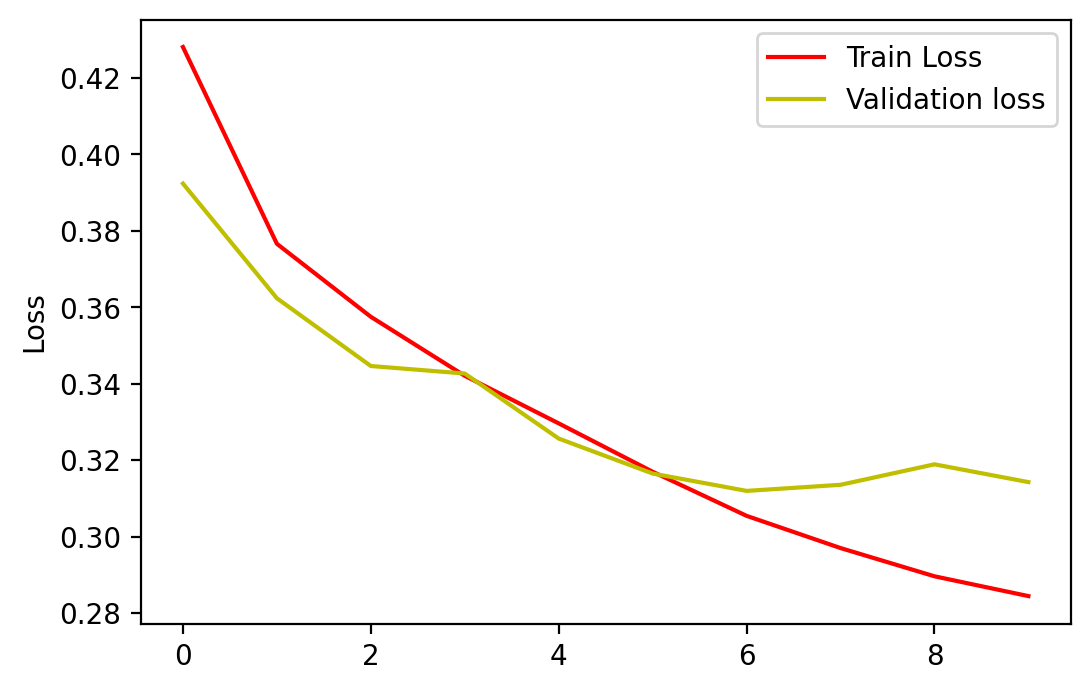

In [ ]:
fig = plt.figure(dpi=200)
plt.ylabel("Loss")
plt.plot(np.array(train_loss_values), 'r')
plt.plot(np.array(valid_loss_values), 'y')
plt.legend(["Train Loss", "Validation loss"], loc ="upper right") 

### Test data

In [ ]:
test_fields = {'question1' : ('q1',question_1), 'question2' : ('q2',question_2)}

In [ ]:
test = pd.read_csv("input/test.csv")

In [ ]:
test['question1'] = test['question1'].apply(lambda x: clean_contractions(str(x),contraction_mapping))
test['question2'] = test['question2'].apply(lambda x: clean_contractions(str(x),contraction_mapping))
test['question1'] = test['question1'].apply(lambda x: remove_newlines(str(x)))
test['question2'] = test['question2'].apply(lambda x: remove_newlines(str(x)))

In [ ]:
test.head()

,test_id,question1,question2
0,0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...
1,1,should i have a hair transplant at age 24? how...,how much cost does hair transplant require?
2,2,what but is the best way to send money from ch...,what you send money to china?
3,3,which food not emulsifiers?,what foods fibre?
4,4,"how ""aberystwyth"" start reading?",how their can i start reading?


In [ ]:
test.to_csv('input/test_split.csv',index = False)

In [ ]:
test_data = TabularDataset(
                            path='input/test_split.csv',
                            format='CSV',
                            fields=test_fields
                        )

In [ ]:
test_iterator = BucketIterator(
    test_data, batch_size=32, device=device,train=False,sort=False)

In [ ]:
model = Net(question_1.vocab.vectors, embedding_size, hidden_size, num_layers, dropout).to(device)

model.load_state_dict(torch.load("models/LSTM-GLOVE-300.bin"))

<All keys matched successfully>

In [ ]:
def predict(data_loader, model, device):
  model.eval()
  all_predictions = []
  with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(data_loader), total=len(data_loader)):
      q1 = batch.q1.to(device=device)
      q2 = batch.q2.to(device=device)
      predictions = model(q1, q2)
      predictions = nn.Sigmoid()(predictions).cpu().tolist()
      all_predictions += predictions
  return all_predictions

In [ ]:
test_predictions = predict(test_iterator, model, device)

In [ ]:
test_predictions = [item[0] for item in test_predictions]

In [ ]:
test['is_duplicate'] = test_predictions

In [ ]:
test_predictions[0]

0.08426652103662491

In [ ]:
test.to_csv('submission_lstm.csv', columns=['test_id','is_duplicate'], index=False)

In [ ]:
!ls

input	      lstm-code.py  runs	      submission.csv  use_model
input_maLSTM  models	    submission_1.csv  train.csv       validation.csv


In [ ]:
test.head()

,test_id,question1,question2,is_duplicate
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,0.137905
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,0.035996
2,2,What but is the best way to send money from Ch...,What you send money to China?,0.020188
3,3,Which food not emulsifiers?,What foods fibre?,0.030641
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,0.039753


In [ ]:
- BiLSTM
- Swap Q1, Q2
- Mnahattan LSTM
- LSTM shared weights
- Common Embedding layer